# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')

from matplotlib import font_manager, rc

font_path="C:/Windows/Fonts/H2HDRM.TTF"
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)

# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
#fontlist[:]
#font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
#font = font_manager.FontProperties(fname=font_path).get_name()
#rc('font', family=font)

In [3]:
data = pd.read_csv("C:/Users/sohee/Desktop/KW/산학연계(졸작)/산학졸작_openUP_Data/kwproja_data_big.csv",encoding='utf-8')
data.head() # original data -> data

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price
0,201709,24432350113,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,21514
1,201709,13141330215,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,52264
2,201706,39421720107,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,42656
3,201706,4602500509,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,34561
4,201709,39313780106,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,38423


# EDA 

2,927,739 rows X 9 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
  - shop_name -> input feature로는 사용하지 않음 (NLP deep learning 가능성 있음)
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
  - shop_type_big -> 15 category  -> 업종 (매출 영향성 있음)
  - shop_type_small -> 61 category

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X


##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain

In [ ]:
data.columns

In [ ]:
data.info()

# 3. Preprocessing
data -> processed_data
- 9 columns : **shop_code | date | shop_name | shop_type_big | shop_type_small | longitude | latitude | average_sale_price | monthly_gain**
- shop_code : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
- missing value 제거 : A/N
- shop_type_big(15), shop_type_small(61) 
    - ML : label encodding
    - DL : NLP
- longitude, latitude : 
    - ML : k-mean clustering -> geo column 
    - DL : NLP, reverse geo encoder(행정동, 법정동, 지번주소, 도로명주소) -> 지번주소 가져오세요(for web) 
    - 행정동admcode, 법정동legalcode -> area1, area2, area3, area4
    - 지번 주소addr -> area1, area2, area3, area4 (x), land -> namber1, number2
    - 도로명 주소roadaddr -> area1, area2, area3, area4(x), land -> number1, number2, name  
- average_sale_price 
    - log transformation 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는?? 실험필요 요인 

In [4]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# feature drop : date, shop_code
processed_data = data.drop(['date', 'shop_code'], axis=1).copy()

In [6]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = processed_data[processed_data['monthly_gain']==0].index 
print("monthly gain null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - average_sale_price
null_index = processed_data[processed_data['average_sale_price']==0].index 
print("average sale price null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_big
null_index = processed_data[processed_data['shop_type_big'].isnull()==True].index
print("shop type big null : ", len(null_index))
print("shop type big unique : ", processed_data['shop_type_big'].nunique())
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_small 
null_index = processed_data[processed_data['shop_type_small'].isnull()==True].index
print("shop type small null : ", len(null_index))
print("shop type small unique : ", processed_data['shop_type_small'].nunique() )

monthly gain null :  0
average sale price null :  0
shop type big null :  0
shop type big unique :  15
shop type small null :  0
shop type small unique :  61


In [7]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# fit transform으로 한번에 처리 가능
le = LabelEncoder()
processed_data['shop_type_big_label'] = le.fit_transform(list(processed_data['shop_type_big']))   
print(le.classes_)

le = LabelEncoder()
processed_data['shop_type_small_label'] = le.fit_transform(list(processed_data['shop_type_small'])) 
print(le.classes_)

# NLP용 preprocessing 
# shop_name, shop_type_big, shop_type_small = concat_text 
processed_data['concat_text'] = processed_data['shop_name'] + " " + processed_data['shop_type_big'] + " " + processed_data['shop_type_small']

['다방/커피숍/카페' '별식/퓨전요리' '분식' '뷔페' '생활서비스' '소매' '수산물' '양식' '유흥주점' '음식-미분류'
 '일식' '제과제빵떡케익' '중식' '패스트푸드' '한식']
['고기 뷔페' '고기구이/육회 전문점' '곱창/양구이 전문점' '구내식당' '국수/수제비 전문점' '기타세계요리 전문점'
 '낙지/문어/오징어/쭈꾸미 전문점' '냉면 전문점' '덮밥/가정식' '도너츠/꽈배기/고로케/호떡 전문점'
 '도시락/컵밥/주먹밥/배달음식 전문점' '돈가스 전문점' '떡/한과 전문점' '마라/양꼬치/훠궈 전문점' '면 전문점'
 '미분류 유흥업소' '민속주점' '바닷가재/게요리 전문점' '반찬 판매' '백화점' '버거 전문점' '베트남음식 전문점'
 '보쌈/족발 전문점' '분식 전문점' '샌드위치/토스트/핫도그 전문점' '샤브샤브 전문점' '세탁소' '소주방/포장마차'
 '순대 전문점' '슈퍼/잡화/할인매장' '스테이크 전문점' '식료품' '아이스크림/빙수 판매' '오리/닭요리 전문점'
 '오리/닭요리/탕/백숙 전문점' '와인/칵테일/위스키 바' '음식-미분류' '이자까야/꼬치구이' '이태리 전문점'
 '인도음식 전문점' '일반 중식당' '장어 전문점' '전통찻집' '제과/제빵 전문점' '조개 전문점' '종합 뷔페'
 '죽요리 전문점' '참치 전문점' '초밥 전문점' '치킨/닭강정 전문점' '카레 전문점' '카페/디저트' '테이크아웃 음료 전문점'
 '편의점' '퓨전음식 전문점' '피자 전문점' '한식국물요리 전문점' '한정식/백반 전문점' '호프/맥주' '화로구이 전문점'
 '회/수산물 일반']


In [8]:
# BinaryEncoder for categorical variable 
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["shop_type_big", "shop_type_small"])
df = encoder.fit_transform(processed_data[["shop_type_big", "shop_type_small"]])

processed_data = pd.concat([processed_data, df], axis=1)

[[ 37.50145315 127.0345484 ]
 [ 37.49492214 126.89670518]
 [ 37.57056986 127.06802797]
 [ 37.51701008 127.12121286]
 [ 37.57393295 126.92466401]
 [ 37.56625292 126.99479323]
 [ 37.53984586 126.8456821 ]
 [ 37.63891902 127.04531704]
 [ 37.49660874 126.9521345 ]]
[6 3 1 ... 2 3 1]


Text(0.5, 1.0, 'k-mean')

c:\users\sohee\appdata\local\programs\python\python38\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


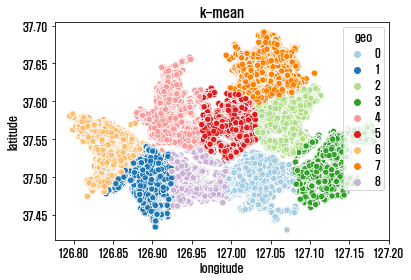

In [9]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(processed_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

processed_data['geo'] = kmeans.labels_

# plotting geo
sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=processed_data, palette="Paired")
plt.title('k-mean')

# NLP 처리를 위해서 featrue drop은 생략합니다! 
#processed_data = processed_data.drop(['longitude', 'latitude'], axis=1)

In [10]:
# average_sale_price -> skewed data 
# log transfromation 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']
processed_data[scale_cols] = processed_data[scale_cols].apply(lambda x : np.log1p(x))

processed_data

,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,concat_text,...,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,geo
0,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,9.976506,3,0,친쿡부대찌개 오류동본점 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,6
1,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,10.864082,3,0,드럼통집 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,3
2,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,10.660947,3,0,하우돈 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,1
3,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,10.450510,3,0,고고생고기 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,3
4,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,10.556438,3,0,현대식당 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,수산물,회/수산물 일반,126.963825,37.526863,13693767.90,9.976366,6,60,최가네 남원추어탕 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,8
2927735,우미도라꾸,수산물,회/수산물 일반,127.070132,37.536551,17432801.29,11.219359,6,60,우미도라꾸 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,2
2927736,연안해물칼국수 행당점,수산물,회/수산물 일반,127.033712,37.559118,17023101.74,10.440361,6,60,연안해물칼국수 행당점 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,2
2927737,동해수산,수산물,회/수산물 일반,127.127448,37.537151,31533908.77,10.877557,6,60,동해수산 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,3


In [11]:
# removing outlier 
# upper fence, lower fence 외 값(outlier)를 제거합니다 
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def remove_outlier(data) :
    output_data = data.copy()
    for i in range(0,15) :
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, data)
        shoptype_index = data[data.shop_type_big_label == i].index
        shoptype_data = data.iloc[shoptype_index, :]
        outlier_index = shoptype_data[shoptype_data.monthly_gain > upper_fence].index
        print("removed index in shop_type_big" , i, ": ", len(outlier_index))
        output_data = output_data.drop(outlier_index)
    return output_data 

processed_data = remove_outlier(processed_data)
processed_data

removed index in shop_type_big 0 :  25133
removed index in shop_type_big 1 :  15726
removed index in shop_type_big 2 :  12003
removed index in shop_type_big 3 :  2393
removed index in shop_type_big 4 :  1
removed index in shop_type_big 5 :  26678
removed index in shop_type_big 6 :  8612
removed index in shop_type_big 7 :  1188
removed index in shop_type_big 8 :  19350
removed index in shop_type_big 9 :  50532
removed index in shop_type_big 10 :  6064
removed index in shop_type_big 11 :  5384
removed index in shop_type_big 12 :  8360
removed index in shop_type_big 13 :  11580
removed index in shop_type_big 14 :  40136


,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,concat_text,...,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,geo
0,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,9.976506,3,0,친쿡부대찌개 오류동본점 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,6
1,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,10.864082,3,0,드럼통집 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,3
2,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,10.660947,3,0,하우돈 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,1
3,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,10.450510,3,0,고고생고기 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,3
4,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,10.556438,3,0,현대식당 뷔페 고기 뷔페,...,0,0,1,0,0,0,0,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,수산물,회/수산물 일반,126.963825,37.526863,13693767.90,9.976366,6,60,최가네 남원추어탕 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,8
2927735,우미도라꾸,수산물,회/수산물 일반,127.070132,37.536551,17432801.29,11.219359,6,60,우미도라꾸 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,2
2927736,연안해물칼국수 행당점,수산물,회/수산물 일반,127.033712,37.559118,17023101.74,10.440361,6,60,연안해물칼국수 행당점 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,2
2927737,동해수산,수산물,회/수산물 일반,127.127448,37.537151,31533908.77,10.877557,6,60,동해수산 수산물 회/수산물 일반,...,1,0,1,1,1,1,1,0,1,3


# 4. 타겟변수 확인
why(or when) to use log transform in ML? 
- target variable이 non-negative values 일때만 
- outlier 값들도 사용해야 하는 경우, outliers that can't be filtered out as they are important to the model.
- 현재 주어진 data도 좌측으로 치우쳐진 (right skewed) 형태, 굉장히 극소수의 업종들만이 굉장히 큰 매출을 만들어낼 수 있는 것으로 보임 
- 어떤 column, feature가 가장 monthly_gain과 상관관계가 높을까요? 
- kaggle house price prediction 대회에서도 RMSE가 아닌 RMSLE를 사용함 -> log를 씌운 형태인데 target variable인 집값의 범위가 넒기 때문

- Skewness: The longer the right tail, the more positive the tail
- Kurtosis (kurtosis / kurtosis): If the kurtosis value (K) is close to 3, the scatter is close to the normal distribution. (K <3), the distributions can be judged to be flattened more smoothly than the normal distribution, and if the kurtosis is a positive number larger than 3 (K> 3), the distribution can be considered to be a more pointed distribution than the normal distribution

In [12]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

# 5. Data Split 
전처리 완료, 필요한 column을 input으로 넣고 train / valid / test data split 

In [13]:
# 전처리된 data와 따로 관리 -> processed_data, model input data = input_data 
input_data = processed_data.copy()

input_data_X = input_data.drop(['monthly_gain'],axis=1)
input_data_y = input_data['monthly_gain'].copy()

In [14]:
input_data_X

,shop_name,shop_type_big,shop_type_small,longitude,latitude,average_sale_price,shop_type_big_label,shop_type_small_label,concat_text,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,geo
0,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.84,37.50,9.98,3,0,친쿡부대찌개 오류동본점 뷔페 고기 뷔페,0,0,0,1,0,0,0,0,0,1,6
1,드럼통집,뷔페,고기 뷔페,127.10,37.51,10.86,3,0,드럼통집 뷔페 고기 뷔페,0,0,0,1,0,0,0,0,0,1,3
2,하우돈,뷔페,고기 뷔페,126.91,37.52,10.66,3,0,하우돈 뷔페 고기 뷔페,0,0,0,1,0,0,0,0,0,1,1
3,고고생고기,뷔페,고기 뷔페,127.11,37.50,10.45,3,0,고고생고기 뷔페 고기 뷔페,0,0,0,1,0,0,0,0,0,1,3
4,현대식당,뷔페,고기 뷔페,126.98,37.52,10.56,3,0,현대식당 뷔페 고기 뷔페,0,0,0,1,0,0,0,0,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,수산물,회/수산물 일반,126.96,37.53,9.98,6,60,최가네 남원추어탕 수산물 회/수산물 일반,0,1,0,1,1,1,1,1,0,1,8
2927735,우미도라꾸,수산물,회/수산물 일반,127.07,37.54,11.22,6,60,우미도라꾸 수산물 회/수산물 일반,0,1,0,1,1,1,1,1,0,1,2
2927736,연안해물칼국수 행당점,수산물,회/수산물 일반,127.03,37.56,10.44,6,60,연안해물칼국수 행당점 수산물 회/수산물 일반,0,1,0,1,1,1,1,1,0,1,2
2927737,동해수산,수산물,회/수산물 일반,127.13,37.54,10.88,6,60,동해수산 수산물 회/수산물 일반,0,1,0,1,1,1,1,1,0,1,3


In [15]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True
)

# 6. Modeling

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import Ridge,Lasso

In [19]:
# ml용 data에는 _ml을 붙여줍니다 
train_X_ml = train_X.drop(['shop_name', 'shop_type_big', 'shop_type_small', 'longitude', 
                           'latitude', 'concat_text', 'shop_type_big_label', 'shop_type_small_label'], axis=1).copy()
valid_X_ml = valid_X.drop(['shop_name', 'shop_type_big', 'shop_type_small', 'longitude', 
                           'latitude', 'concat_text', 'shop_type_big_label', 'shop_type_small_label'], axis=1).copy()
test_X_ml = test_X.drop(['shop_name', 'shop_type_big', 'shop_type_small', 'longitude',
                         'shop_type_big_label', 'shop_type_small_label', 'latitude', 'concat_text'], axis=1).copy()

print(len(train_X))
print(len(train_X_ml))
print(len(valid_X))
print(len(valid_X_ml))
print(len(test_X))
print(len(test_X_ml))

1724543
1724543
431136
431136
538920
538920


In [20]:
train_X_ml

,average_sale_price,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,geo
1888497,9.94,0,1,0,0,1,1,0,0,1,0,4
2920384,10.25,0,1,0,1,1,1,1,1,0,1,7
2290882,8.76,1,1,1,1,1,1,0,1,0,0,3
1236797,8.83,1,1,1,0,1,0,0,1,0,1,4
1481264,8.01,1,1,1,0,1,0,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
990741,10.55,1,0,1,1,1,0,0,0,0,0,4
1068017,10.89,0,1,0,0,1,0,0,0,1,0,2
2410866,8.34,1,0,1,1,1,1,0,1,1,0,2
2047673,9.29,1,1,1,1,1,1,0,1,0,0,7


#### XGB

In [21]:
model_xgb = XGBRegressor()

In [22]:
model_xgb.fit(train_X_ml,train_y,eval_set=[(valid_X_ml,valid_y)])

[0]	validation_0-rmse:18273422.00000
[1]	validation_0-rmse:15994233.00000
[2]	validation_0-rmse:14713882.00000
[3]	validation_0-rmse:14023053.00000
[4]	validation_0-rmse:13661854.00000
[5]	validation_0-rmse:13469798.00000
[6]	validation_0-rmse:13332370.00000
[7]	validation_0-rmse:13274781.00000
[8]	validation_0-rmse:13241933.00000
[9]	validation_0-rmse:13202064.00000
[10]	validation_0-rmse:13164985.00000
[11]	validation_0-rmse:13151367.00000
[12]	validation_0-rmse:13147127.00000
[13]	validation_0-rmse:13136029.00000
[14]	validation_0-rmse:13125101.00000
[15]	validation_0-rmse:13123259.00000
[16]	validation_0-rmse:13118865.00000
[17]	validation_0-rmse:13103648.00000
[18]	validation_0-rmse:13080255.00000
[19]	validation_0-rmse:13078717.00000
[20]	validation_0-rmse:13072564.00000
[21]	validation_0-rmse:13067577.00000
[22]	validation_0-rmse:13054744.00000
[23]	validation_0-rmse:13053261.00000
[24]	validation_0-rmse:13041487.00000
[25]	validation_0-rmse:13040462.00000
[26]	validation_0-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [23]:
pred_xgb = model_xgb.predict(test_X_ml)
pred_xgb

array([27769626. ,  7641046.5,  7878429. , ..., 12979837. , 10622494. ,
       22053060. ], dtype=float32)

#### LGBM

In [ ]:
model_lgbm = LGBMRegressor()

In [ ]:
model_lgbm.fit(train_X_ml,train_y,eval_set=[(valid_X_ml,valid_y)])

In [ ]:
pred_lgbm = model_lgbm.predict(test_X_ml)
pred_lgbm

#### Ridge

In [ ]:
# RIdge 모델 (parameter 적용)
from sklearn.linear_model import RidgeCV #parameter를 넣어준다는거에서 ridge랑 다름

alphas = [0, 0.001, 0.01, 0.1, 1]

# RidgeCV는 alpha로 넣고자 하는 값들을 리스트로 전달하면 내부적으로 최적의 alpha값을 찾아냄
ridgecv = RidgeCV(alphas=alphas, normalize=True, cv=5)
# cv : cross-validation -> 데이터를 k등분한 후 각각에 대하여 검증 진행
# 검증 결과 가장 점수가 높은 모델을 채택
ridgecv.fit(train_X_ml, train_y)
ridgecv_pred = ridgecv.predict(test_X_ml)

mae = mean_absolute_error(test_y, ridgecv_pred)
r2 = r2_score(test_y, ridgecv_pred)
print(f'Test MAE: ${mae:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

print(f'alpha: {ridgecv.alpha_}') # 최종 결정된 alpha값
print(f'cv best score: {ridgecv.best_score_}') # 최종 alpha에서의 점수(R^2 of self.predict(X) wrt. y.)

In [ ]:
#위의 alpha값 넣어준 후 학습 진행하기
model_ridge=Ridge(alpha=0.01)

In [ ]:
model_ridge.fit(train_X_ml,train_y),eval_set=[(valid_X_ml,valid_y)])

In [ ]:
pred_ridge = model_ridge.predict(test_X_ml)
pred_ridge

#### Lasso

In [ ]:
# Parameter 튜닝시도

In [ ]:
model_lasso=Lasso()
model_lasso.fit(train_X_ml,train_y),eval_set=[(valid_X_ml,valid_y)])
print(model_lasso.score(train_X_ml,train_y))
print(model_lasso.score(test_X_ml,test_y))

In [ ]:
train_score=[]
test_score=[]
alpha_list=[0.001,0.01,0.1,1,10,100]
for alpha in alpha_list:
    model_lasso=Lasso(alpha=alpha,max_iter=10000)
    model_lasso.fit(train_X_ml,train_y)
    train_score.append(model_lasso.score(train_X_ml,train_y))
    test_score.append(model_lasso.score(test_X_ml,test_y))
plt.plot(np.log10(alpha_list),train_score)
plt.plot(np.log10(alpha_list),test_score)
plt.show()

In [ ]:
#test1
lasso1= Lasso(alpha=0.01, max_iter=100000).fit(train_X_ml, train_y)

print("훈련 세트의 정확도 : {:.2f}".format(lasso1.score(train_X_ml, train_y)))

print("테스트 세트의 정확도 : {:.2f}".format(lasso1.score(test_X_ml, test_y)))

print("사용한 특성의 수 : {}".format(np.sum(lasso1.coef_ != 0)))

print("사용한 max_iter : {}".format(lasso1.n_iter_))

In [ ]:
# --> 차이점이 보이지 않아 default값으로 구현
model_lasso=Lasso()

In [ ]:
model_lasso.fit(train_X_ml,train_y),eval_set=[(valid_X_ml,valid_y)])

In [ ]:
pred_lasso = model_lasso.predict(test_X_ml)
pred_lasso

## NLP

In [24]:
from keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(input_data['concat_text'])

print(list(tk.word_index.items())[:20])
print("\nvocab words 개수 : ", len(tk.word_index.items()))

[('전문점', 1), ('미분류', 2), ('음식', 3), ('카페', 4), ('한식', 5), ('소매', 6), ('분식', 7), ('커피숍', 8), ('다방', 9), ('디저트', 10), ('유흥주점', 11), ('퓨전요리', 12), ('별식', 13), ('수산물', 14), ('편의점', 15), ('일반', 16), ('육회', 17), ('고기구이', 18), ('식료품', 19), ('패스트푸드', 20)]

vocab words 개수 :  114561


In [25]:
from keras.preprocessing.sequence import pad_sequences

seq_data = tk.texts_to_sequences(input_data['concat_text'])
print("seq_data[0]: ", seq_data[0])

pad_seq_data = pad_sequences(seq_data)
print("pad_seq_data.shpae: ", pad_seq_data.shape)

nlp_input_length = pad_seq_data[0].shape[0]
print("nlp_input_length", nlp_input_length)

seq_data[0]:  [20951, 20952, 41, 88, 41]
pad_seq_data.shpae:  (2694599, 13)
nlp_input_length 13


In [26]:
def word_embedding(df, nlp_input_length) :
    seq_data = tk.texts_to_sequences(df)
    pad_seq_data = pad_sequences(seq_data, nlp_input_length)
    word_embedding = pad_seq_data
    return word_embedding

train_X_dl = word_embedding(train_X['concat_text'], nlp_input_length)
valid_X_dl = word_embedding(valid_X['concat_text'], nlp_input_length)
test_X_dl = word_embedding(test_X['concat_text'], nlp_input_length)

print(len(train_X))
print(len(train_X_dl))
print(len(valid_X))
print(len(valid_X_dl))
print(len(test_X))
print(len(test_X_dl))   

1724543
1724543
431136
431136
538920
538920


In [ ]:
from keras import Sequential
from keras.layers import *
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def create_model(input_dim, output_dim, input_length=nlp_input_length) : 
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length = nlp_input_length))    
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.add(Dense(len(set(input_data_y)), activation='linear'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_dim = len(tk.word_index) + 1
output_dim = 10

model_dl = create_model(input_dim, output_dim)
model_dl.summary()

In [ ]:
hist = model_dl.fit(train_X_dl, train_y, validation_data=(valid_X_dl, valid_y), epochs=10, batch_size=64)

In [ ]:
pred_dl= model_dl.predict(test_X_dl)
pred_dl

## Evaluation

#### prediction을 확인 후 코드 재작성이 필요

In [ ]:
from sklearn.metrics import accuracy_score, regression_report, confusion_matrix, f1_score

def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)
    
def show_mae(test_y,pred):    
    mae = mean_absolute_error(test_y, pred)
    print("mae : %f" %mae)

def show_r2_score(test_y, pred, test_X_ml) : 
    r2 = r2_score(pred, test_y)
    print("r2 : %f " % r2)
    adj_r2 = 1 - (1-r2)*(test_X.shape[0]-1)/(test_X_ml.shape[0]-test_X_ml.shape[1]-1)
    print("adj_r2_score : %f \n" % adj_r2)


In [ ]:
# XGB
show_pred(test_y, pred_dl)

In [ ]:
show_mse_rmse(test_y, pred_dl)
show_mae(test_y,pred_dl)
show_r2_score(test_y, pred_dl, test_X_ml)